In [1]:
import os
import re
import glob
import json
import random
import argparse
import pandas as pd
import numpy as np

import librosa
import librosa.display
import soundfile as sf

from tqdm import tqdm
import subprocess
import matplotlib.pyplot as plt
from convert_romaji import Romaji2Kana

import cutlet

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from transformers import (
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    TFWav2Vec2ForCTC,
    logging)

from convert_romaji import Romaji2Kana

def seed_everything(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Random seed set.")

seed_everything(42)
tf.get_logger().setLevel('FATAL')
logging.set_verbosity_error()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Random seed set.


In [2]:
def ArgParser():
    parser = argparse.ArgumentParser()

    # DataLoader
    parser.add_argument("--main_dir", default="E://Datasets/Acoustic_model")
    parser.add_argument("--sample_rate", default=16000)
    parser.add_argument("--test_size", default=0.1)
    parser.add_argument("--random_state", default=42)
    parser.add_argument("--batch_size", default=4)
    parser.add_argument("--n_shards", default=40)
    parser.add_argument("--buffer_size", default=512)
    parser.add_argument("--n_samples", default=50000)

    # Trainer
    parser.add_argument("--model_name", default="facebook/wav2vec2-base")
    parser.add_argument("--epochs", default=30)

    # Scheduler
    parser.add_argument("--learning_rate", default=1e-5)
    parser.add_argument("--lr_start", default=1e-8)
    parser.add_argument("--lr_min", default=1e-10)
    parser.add_argument("--lr_max", default=1e-5)
    parser.add_argument("--n_cycles", default=0.5)
    parser.add_argument("--warmup_epochs", default=5)
    parser.add_argument("--sustain_epochs", default=0)

    args = parser.parse_known_args()[0]

    with open(f"{args.main_dir}/vocab.json", "r") as f:
        vocab_size = len(json.load(f))
   
    n_train = int(args.n_samples * (1 - args.test_size))
    n_val = int(args.n_samples * args.test_size)
    train_steps = int(np.ceil(n_train / args.batch_size))
    val_steps = int(np.ceil(n_val / args.batch_size))

    parser.add_argument("--vocab_size", default=vocab_size)
    parser.add_argument("--n_train", default=n_train)
    parser.add_argument("--n_val", default=n_val)
    parser.add_argument("--train_steps", default=train_steps)  
    parser.add_argument("--val_steps", default=val_steps)
    
    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(batch_size=4, buffer_size=512, epochs=30, learning_rate=1e-05, lr_max=1e-05, lr_min=1e-10, lr_start=1e-08, main_dir='E://Datasets/Acoustic_model', model_name='facebook/wav2vec2-base', n_cycles=0.5, n_samples=50000, n_shards=40, n_train=45000, n_val=5000, random_state=42, sample_rate=16000, sustain_epochs=0, test_size=0.1, train_steps=11250, val_steps=1250, vocab_size=37, warmup_epochs=5)

# Preprocessing

In [3]:
class Dataset:
    def __init__(self, args):
        self.args = args
        self.data_dir = "E:/Datasets/Acoustic_model/raw_data"
        self.data = pd.concat([
            self.get_kokoro(),
            self.get_jsut(),
            self.get_commonvoice()], 
            ignore_index=True)
        self.kanji_unicode = self.get_kanji_unicode()
        self.katsu = cutlet.Cutlet()
        self.katsu.use_foreign_spelling = False
    
        tqdm.pandas()
        # Remove rows that contains non-kanji characters
        self.data = self.data[self.data['sentence'].progress_apply(self.check_kanji)] 

        # Remove words within parenthesis
        parenthesis =  r"\（.*\）|\(.*\)|\「.*\」|\『.*\』"
        self.data = self.data[~self.data['sentence'].str.contains(parenthesis)]

        # Remove punctuations from sentences
        self.data['sentence'] = self.data['sentence'].progress_apply(self.clean_kanji)
        self.data['romaji'] = self.data['sentence'].progress_apply(self.kanji2romaji)
        self.data['length'] = self.data['path'].progress_apply(self.get_length)
        self.data = self.data[self.data['length'].between(48000, 100000)]
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.sample(n=self.args.n_samples, random_state=42, ignore_index=True)
        self.data.sort_values(by="length", axis=0, ascending=True, inplace=True, ignore_index=True)
        self.data.to_csv(
            f"{self.args.main_dir}/ASRDataset.csv", 
            encoding="utf-8", index=False)

    def get_kokoro(self):
        data = []
        transcript_path = f"{self.data_dir}/KOKORO-dataset/transcripts/*.metadata.txt"
        for transcript in glob.glob(transcript_path):
            with open(transcript, "r", encoding="utf-8") as f:
                for line in f.readlines():
                    data.append(line.split("|"))

        data = pd.DataFrame(
            data, columns=[
                'text_id', 'path', 'start_idx', 
                'end_idx', 'sentence', 'phonemes'])       

        # paths = data['path'].unique()
        # for path in tqdm(paths, total=len(paths)):
        #     folder_name = path.split("_", 1)[0]
        #     in_path = os.path.join(f"{self.data_dir}/KOKORO-dataset", folder_name, path)
        #     y, sr = librosa.load(in_path, sr=None)
        #     for text_id in data.loc[data['path']==path, 'text_id']:
        #         out_path = os.path.join(self.args.main_dir, 'wav_cleaned', text_id) + ".wav"
        #         if not os.path.exists(out_path):
        #             start_idx = int(data.loc[data['text_id']==text_id, 'start_idx'].item())
        #             end_idx = int(data.loc[data['text_id']==text_id, 'end_idx'].item())
        #             y_slice = librosa.resample(
        #                 y[start_idx:end_idx], orig_sr=sr, target_sr=self.args.sample_rate)
        #             sf.write(out_path, y_slice, samplerate=self.args.sample_rate, subtype='PCM_16')

        data = data[['text_id', 'sentence']]
        data['text_id'] = data['text_id'].apply(lambda x: x + ".wav")
        data.columns = ['path', 'sentence']
        data['corpus'] = ['kokoro'] * len(data)
        return data

    def get_jsut(self):
        filenames, sentences = [], []
        for transcript in glob.glob(f"{self.data_dir}/JSUT-dataset/*/transcript_utf8.txt"):
            file_path = transcript.rsplit("\\", 1)[0]
            with open(transcript, "r", encoding="utf-8") as f:
                lines = f.readlines()
                for line in lines: 
                    filename, sentence = line.split(":")
                    filenames.append(os.path.join(file_path, "wav", filename) + ".wav")
                    sentences.append(sentence.strip("\n"))
        data = pd.DataFrame({'path': filenames, 'sentence': sentences}) 
        data['corpus'] = ['jsut'] * len(data)
        for i, in_path in tqdm(enumerate(data['path']), total=len(data['path'])):
            in_path = in_path.replace("\\", "/")
            out_path = f"{self.args.main_dir}\wav_cleaned"
            filename = in_path.rsplit("/", 1)[-1]
            out_path = os.path.join(out_path, filename)
            if not os.path.exists(out_path):
                subprocess.call([
                    "ffmpeg", "-i", in_path,"-acodec", "pcm_s16le", 
                    "-ar", str(self.args.sample_rate), out_path])
            data['path'][i] = filename
        return data

    def get_commonvoice(self):
        data = pd.read_csv(f"{self.data_dir}/CommonVoice-dataset/validated.tsv", sep="\t")
        data = data[['path', 'sentence']]    
        data['path'] = data['path'].apply(
            lambda x: f"{self.data_dir}/CommonVoice-dataset/clips/" + x)
        data['corpus'] = ['common_voice'] * len(data)
        for i, in_path in tqdm(enumerate(data['path']), total=len(data['path'])):
            in_path = in_path.replace("\\", "/")
            out_path = f"{self.args.main_dir}\wav_cleaned"
            filename = in_path.rsplit("/", 1)[-1]
            filename = filename.replace("mp3", "wav")
            out_path = os.path.join(out_path, filename)
            if not os.path.exists(out_path):
                subprocess.call([
                    "ffmpeg", "-i", in_path,"-acodec", "pcm_s16le", 
                    "-ar", str(self.args.sample_rate), out_path])
            data['path'][i] = filename
        return data

    def get_kanji_unicode(self):
        vocab = set()
        with open(
            f"{self.data_dir}/kanji_unicode.txt", 
            encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                for char in line.split()[1:]:
                    vocab.add(char)
        return "".join(sorted(vocab))
    
    def check_kanji(self, sentence):
        pattern = f"[^{self.kanji_unicode}]"
        if re.match(pattern, sentence) == None:
            return True
        else:
            return False
    
    def clean_kanji(self, sentence):
        sentence = "".join(sentence.split())
        pattern = r"[・\。\！\.\？\、]"
        sentence = re.sub(pattern, "", sentence)
        return sentence

    def kanji2romaji(self, sentence):
        try:
            sentence = self.katsu.romaji(sentence)
            sentence = sentence.replace(" ", "").lower()
        except:
            sentence = None
        return sentence

    def get_length(self, path):
        path = os.path.join(self.args.main_dir, 'wav_cleaned', path)
        y, sr = librosa.load(path, sr=None)
        return len(y)

# data = Dataset(args).data
# data

In [4]:
# plt.figure(figsize=(10, 4))
# sns.histplot(x=data['length'], hue=data['corpus'], palette="bright")
# plt.show()

# Data Loading

In [5]:
class Config:
    def __init__(self, args):
        tokenizer = Wav2Vec2CTCTokenizer(
            vocab_file=f"{args.main_dir}/vocab.json",
            do_lower_case=False)

        feature_extractor = Wav2Vec2FeatureExtractor(
            feature_size=1,
            sampling_rate=args.sample_rate,
            padding_value=0.0,
            do_normalize=False,
            return_attention_mask=False)

        self.processor = Wav2Vec2Processor(
            feature_extractor=feature_extractor,
            tokenizer=tokenizer)

In [6]:
class TFRWriter():
    def __init__(self, args):
        self.data = pd.read_csv(os.path.join(args.main_dir, "ASRDataset.csv"), encoding="utf-8")
        self.args = args
        self.config = Config(args)

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _float_feature(self, value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'input_values': self._bytes_feature(args[0]),
            'labels': self._bytes_feature(args[1])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_labels(self, sample):
        labels = self.data.loc[self.data['path']==sample, "romaji"].item()
        labels = (self.config.processor.tokenizer.bos_token + labels + 
            self.config.processor.tokenizer.eos_token)
        labels = self.config.processor.tokenizer(labels, is_split_into_words=True).input_ids
        return tf.convert_to_tensor(labels, dtype=tf.int32)

    def get_audio(self, sample):
        path = os.path.join(self.args.main_dir, "wav_cleaned", sample)
        audio = librosa.load(path, sr=None)[0]
        return tf.convert_to_tensor(audio, dtype=tf.float32)

    def get_shards(self):
        skf = KFold(n_splits=self.args.n_shards, shuffle=False)
        return [
            list(map(lambda x: self.data['path'][x], j))
            for i, j in skf.split(self.data['path'])]

    def get_shard_data(self, samples):
        for sample in samples:
            audio = self.get_audio(sample)
            labels = self.get_labels(sample)
            yield {
                'input_values': tf.io.serialize_tensor(audio),
                'labels': tf.io.serialize_tensor(labels)}

    def write(self):
        for shard, samples in tqdm(enumerate(self.get_shards()), total=self.args.n_shards):
            with tf.io.TFRecordWriter(f"{self.args.main_dir}/wav2vec2_tfrec/shard_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples):
                    example = self.serialize_example(
                        sample['input_values'],
                        sample['labels'])
                    f.write(example)

# TFRWriter(args).write()

In [7]:
class DataLoader:
    def __init__(self, args):
        self.files = glob.glob(args.main_dir + "/wav2vec2_tfrec/*.tfrec")
        self.args = args
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True, 
            random_state=args.random_state)
        self.train = self.get_train()
        self.val = self.get_val()

    def read_tfrecord(self, example):
        feature_description = {
            'input_values': tf.io.FixedLenFeature([], tf.string),
            'labels': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['input_values'] = tf.io.parse_tensor(
            example['input_values'], out_type=tf.float32)
        example['labels'] = tf.io.parse_tensor(
            example['labels'], out_type=tf.int32)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset

    def get_train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_values': [None],
                'labels': [None]},
            padding_values={
                'input_values': tf.constant(0, dtype=tf.float32), 
                'labels': tf.constant(-100, dtype=tf.int32)})        
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def get_val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_values': [None],
                'labels': [None]},
            padding_values={
                'input_values': tf.constant(0, dtype=tf.float32),
                'labels': tf.constant(-100, dtype=tf.int32)})
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

# train = DataLoader(args).train
# output = next(iter(train))
# output

In [8]:
# plt.figure(figsize=(16,10))
# for i, array in enumerate(train.take(16)):
#     plt.subplot(4, 4, i+1)
#     y = array['input_values'].numpy()
#     librosa.display.waveplot(y=y, sr=16000)

# plt.tight_layout()
# plt.show()

# Model Training

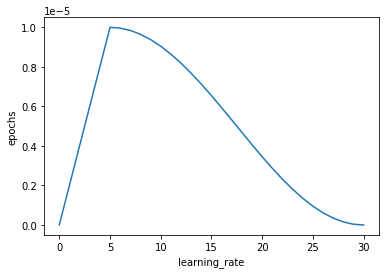

In [9]:
class PERMetric(tf.keras.metrics.Metric):
    def __init__(self, name="PER", **kwargs):
        super(PERMetric, self).__init__(name=name,  **kwargs)
        self.accumulator = self.add_weight(name="total_per", initializer="zeros")
        self.counter = self.add_weight(name="per_count", initializer="zeros")    

    def update_state(self, y_true, y_pred, sample_weight=None):
        hypothesis = tf.cast(tf.sparse.from_dense(y_pred), dtype=tf.int32)

        # Convert dense to sparse tensor for edit_distance function
        truth = tf.RaggedTensor.from_tensor(y_true, padding=0).to_sparse()

        # Calculate Levenshtein distance
        distance = tf.edit_distance(hypothesis, truth, normalize=True)

        # Add distance and number of samples to variables
        self.accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(len(y_true))

    def result(self):
        # Divides accumulated distance scores against number of samples passed,
        # mimics mean reduction over batch
        return tf.math.divide_no_nan(self.accumulator, self.counter)   
    
    def reset_state(self):
        self.accumulator.assign(0.0)
        self.counter.assign(0.0)

class CosineDecayWithWarmup(LearningRateSchedule):
    def __init__(self, args):
        self.args = args

    def __call__(self, epoch):  
        if epoch < self.args.warmup_epochs:
            lr = ((self.args.lr_max - self.args.lr_start) / self.args.warmup_epochs) * epoch + self.args.lr_start
        elif epoch < (self.args.warmup_epochs + self.args.sustain_epochs):
            lr = self.args.lr_max
        else:
            progress = ((epoch - self.args.warmup_epochs - self.args.sustain_epochs) / 
            (self.args.epochs - self.args.warmup_epochs - self.args.sustain_epochs))
            lr = (self.args.lr_max-self.args.lr_min) * (0.5 * (1.0 + tf.math.cos((22/7) * 
                self.args.n_cycles * 2.0 * progress)))
            if self.args.lr_min is not None:
                lr = tf.math.maximum(self.args.lr_min, lr)
        return lr

    def plot(self):
        epochs = range(self.args.epochs+1)
        lr = [self(epoch) for epoch in epochs]
        plt.plot(epochs, lr)
        plt.xlabel("learning_rate")
        plt.ylabel("epochs")
        plt.show()

CosineDecayWithWarmup(args).plot()

In [10]:
class Trainer:
    def __init__(self, args):
        self.args = args
        self.config = Config(args)
        self.train_dataset = DataLoader(args).train
        self.val_dataset = DataLoader(args).val
        schedule = CosineDecayWithWarmup(args)
        self.optimizer = tf.keras.optimizers.Adam(schedule)
        self.per_metrics = PERMetric()
        self.model = TFWav2Vec2ForCTC.from_pretrained(
            args.model_name,
            from_pt=True,
            ctc_loss_reduction="mean",
            gradient_checkpointing=True,
            final_dropout=0.1,
            pad_token_id=self.config.processor.tokenizer.pad_token_id,
            vocab_size=len(self.config.processor.tokenizer))
        self.model.freeze_feature_extractor()
        
        self.model_name = f"model_{int(self.args.n_samples/1000)}k"
        self.log_path = f"{self.args.main_dir}/model_weights/{self.model_name}.csv"
        if not os.path.exists(self.log_path):
            print("Log file created.")
            columns = "epoch,loss,per,val_loss,val_per\n"
            with open(self.log_path, "a") as f:
                f.write(columns)

    def decoder(self, labels, logits):
        labels = tf.where(labels == -100, x=0, y=labels)
        logits = tf.argmax(logits, axis=-1)
        return labels, logits

    def display(self, epoch, t_labels, t_logits, v_labels, v_logits):
        t_labels = self.config.processor.batch_decode(
            t_labels, skip_special_tokens=True, group_tokens=False)
        v_labels = self.config.processor.batch_decode(
            v_labels, skip_special_tokens=True, group_tokens=False)
        t_logits = self.config.processor.batch_decode(
            t_logits, skip_special_tokens=True, group_tokens=False)
        v_logits = self.config.processor.batch_decode(
            v_logits, skip_special_tokens=True, group_tokens=False)

        print("-" * 129)
        print("Training")
        for y_true, y_pred in zip(t_labels, t_logits):
            print(f"Target:    {y_true}")
            print(f"Predicted: {y_pred}") 

        print("\nValidation")
        for y_true, y_pred in zip(v_labels, v_logits):
            print(f"Target:    {y_true}")
            print(f"Predicted: {y_pred}")
        print("-" * 129)

    def fit(self):
        # Checkpoint manager
        self.ckpt_dir = f"{self.args.main_dir}/checkpoints"
        self.ckpt = tf.train.Checkpoint(self.model)
        self.ckpt_manager = tf.train.CheckpointManager(
            checkpoint=self.ckpt, directory=self.ckpt_dir, max_to_keep=5)

        if self.ckpt_manager.latest_checkpoint:
            self.start_epoch = int(self.ckpt_manager.latest_checkpoint.split("-")[-1])
            self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Resuming from epoch {self.start_epoch + 1}...")
        else:
            self.start_epoch = 0
            print("Starting from epoch 1...")

        for epoch in range(self.start_epoch, self.args.epochs+1):
            print(f"Epoch {epoch+1}/{self.args.epochs}: Learning rate @ {self.optimizer.lr(epoch):.2e}")
            stateful_metrics = ["loss", "per", "val_loss", "val_per"]
            progbar = tf.keras.utils.Progbar(
                self.args.train_steps, interval=0.05,
                stateful_metrics=stateful_metrics)

            # Training loop
            for step, t_batch in enumerate(self.train_dataset):
                t_inputs = t_batch['input_values']
                t_labels = t_batch['labels']
                with tf.GradientTape() as tape:
                    t_loss, t_logits = self.model(
                        input_values=t_inputs, labels=t_labels, training=True)[:2]
                gradients = tape.gradient(t_loss, self.model.trainable_weights)  
                self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))  

                t_labels, t_logits = self.decoder(t_labels, t_logits)
                self.per_metrics.update_state(t_labels, t_logits) 
                t_per = self.per_metrics.result()
                t_values = [("loss", t_loss), ("per", t_per)]
                progbar.update(step, values=t_values, finalize=False)
            self.per_metrics.reset_states()
            
            # Validation loop
            for v_batch in self.val_dataset:
                v_inputs = v_batch['input_values']
                v_labels = v_batch['labels']
                v_loss, v_logits = self.model(
                    input_values=v_inputs, labels=v_labels, training=False)[:2]       
                v_labels, v_logits = self.decoder(v_labels, v_logits)         
                self.per_metrics.update_state(v_labels, v_logits)

            v_per = self.per_metrics.result()
            v_values = [
                ("loss", t_loss), ("per", t_per), ("val_loss", v_loss),
                ("val_per", v_per)]
            progbar.update(self.args.train_steps, values=v_values, finalize=True)
            self.per_metrics.reset_states()

            # Print sample transcriptions for both loops
            self.display(epoch, t_labels, t_logits, v_labels, v_logits)

            # Checkpointing
            self.ckpt.save(file_prefix=f"{self.ckpt_dir}/{self.model_name}")

            # Logging
            log = f"{epoch+1},{t_loss},{t_per},{v_loss},{v_per}\n"
            with open(self.log_path, "a") as f:
                f.write(log)

            save_path = f"{self.args.main_dir}/model_weights"
            self.model.save_weights(f"{save_path}/{self.model_name}_{epoch+1}.h5")

Trainer(args).fit()

E:\Anaconda3\envs\tf-gpu\lib\site-packages\transformers\configuration_utils.py:340: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Resuming from epoch 3...
Epoch 3/30: Learning rate @ 4.01e-06
 6506/11250 [================>.............] - ETA: 1:56:14 - loss: 51.3951 - per: 0.3433

## Performance

In [ ]:
# history = pd.read_csv("E:\Datasets\ASR-dataset\model_weights\model_40k.csv", index_col="epoch")
# history

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# sns.lineplot(x=history.index, y=history['per'], label="per", ax=ax1)
# sns.lineplot(x=history.index, y=history['wer'], label="wer", ax=ax2)
# sns.lineplot(x=history.index, y=history['val_per'], label="val_per", ax=ax1)
# sns.lineplot(x=history.index, y=history['val_wer'], label="val_wer", ax=ax2)
# plt.suptitle("Acoustic model")
# plt.tight_layout()
# plt.savefig("acoustic_history.png", transparent=False, bbox_inches='tight')
# plt.show()